## Part 0: Research and Planning



### 1. Dataset Selection

We have chosen the Fashion-MNIST dataset. It consists of 70,000 grayscale images (28x28 pixels) categorized into 10 classes of clothing and accessories. This dataset serves as a more challenging replacement for the original MNIST digits dataset, requiring the model to learn more complex textures and shapes.

### 2. Pretraining Model Selection

- Model: ResNet-50.

- Justification: ResNet (Residual Network) is a standard benchmark in computer vision. Its "skip connections" allow for training deep architectures without the vanishing gradient problem. It is well-suited for Transfer Learning because its early layers capture general features (edges, textures) that are highly applicable to fashion items.

### 3. Transfer Learning Strategy

- Approach: We will use feature extraction by freezing the convolutional base of ResNet-50

- Justification: Freezing the convolutional base allows us to leverage the learned features from ImageNet while only training the final classification layers on our specific dataset. This reduces training time and computational resources while still achieving good performance.

- Modifications: We will replace the final fully connected layer of ResNet-50 with a new dense layer tailored to the 10 classes of the Fashion-MNIST dataset.

- Training: We will train the new classification layer using the Fashion-MNIST training set while keeping the convolutional base frozen. After the initial training of the classification head, we may unfreeze the final convolutional blocks of ResNet-50 and continue training with a lower learning rate to further refine the model for fashion-specific textures.

- Hyperparameters: We will use a learning rate of 0.001 for the classification head and 0.0001 for fine-tuning, with a batch size of 32 and training for 10 epochs initially.

- Optimization: We will use the Adam optimizer for its adaptive learning rate capabilities, which is beneficial for transfer learning scenarios.



### 4. Preprocessing & Augmentation Strategy

- Resize & RGB Conversion: Since ResNet-50 was pretrained on ImageNet (color images), we will resize the 28x28 images to 224x224 and convert grayscale to 3-channel RGB.

- Augmentation: We will use RandomHorizontalFlip and RandomRotation to increase model robustness and prevent overfitting.

- Normalization: We will normalize the pixel values using the standard ImageNet mean and standard deviation to align with the pretrained weights

### 5. Evaluation Metrics

We will monitor Cross-Entropy Loss and Accuracy. We will use TensorBoard to log these metrics for every run to ensure a fair comparison between the pretrained model and the CNN from scratch.

## Part 1: Data Preprocessing and Augmentation

We will implement the preprocessing and augmentation strategies outlined in our planning phase. This includes resizing, converting to RGB, applying augmentations, and normalizing the images.

Import necessary libraries

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import torchvision

#### 1. Setup TensorBoard writer

In [3]:
writer = SummaryWriter('logs/fashion_mnist_experiments')

#### 2. Define Transforms

We resize to 224 for ResNet and convert to 3 channels 

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Grayscale(num_output_channels=3), # Pretrained models expect 3 channels
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet standards
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### 3. Load Dataset

In [5]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=data_transforms['train'])
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


100%|██████████| 26.4M/26.4M [00:04<00:00, 5.63MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 263kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.24MB/s]


#### 4. Exploratory Data Analysis (EDA) - Visualizing the data

In [6]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Get some random training images

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

Show images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8025708].


GroundTruth:  Ankle boot Sneaker Coat Ankle boot


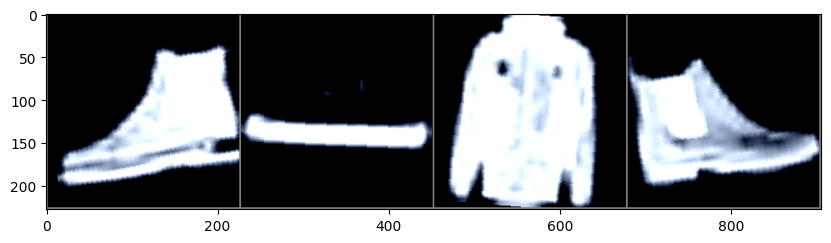

In [14]:
plt.figure(figsize=(10,5))
print('GroundTruth: ', ' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(4)))
imshow(torchvision.utils.make_grid(images[:4]))